In [1]:
import os
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append('/home/golden/coding/drone-tracking/code/functions')
import mapping_functions as kmap
import koger_general_functions as kgf

In [2]:
observation_name = 'observation046'

kenya_drones_path = "/home/golden/kenya_drones"
maps_folder = os.path.join(kenya_drones_path,
                           "3D_mapping/small_maps"
                          )
tracks_folder = os.path.join(kenya_drones_path,
                             'processing/kenya-tracking/processed-videos/raw-footage',
                             observation_name
                            )

tracks_file = os.path.join(tracks_folder, 
                           "localizations/tracks-complete.npy"
                          )
tracks_frame = np.load(tracks_file, allow_pickle=True)


utms_file = os.path.join(tracks_folder, 'fixed_utm_tracks-1.0.npy')
tracks_utm = np.load(utms_file, allow_pickle=True)

frame_folders_root = os.path.join(kenya_drones_path, 
                                  "processing/kenya-tracking/raw-frames/raw-footage",
                                  observation_name
                                 )
frame_files = kgf.get_observation_frame_files(frame_folders_root)

pix4d_folder = os.path.join(maps_folder, observation_name)

geotif_image_file = os.path.join(pix4d_folder,
                                 "3_dsm_ortho/2_mosaic",
                                 f"{observation_name}_transparent_mosaic_group1.tif"
                                )
image_gtif = gdal.Open(geotif_image_file)

bands = []
for band_num in range(1, 4):
    srcband = image_gtif.GetRasterBand(band_num)
    a = srcband.ReadAsArray()
    bands.append(a)
image_map = np.stack(bands, 2)

map_shape = image_map.shape

# Get information for converting between utm and raster coordinates
image_transform = image_gtif.GetGeoTransform()
x_origin = image_transform[0]
y_origin = image_transform[3]
pixel_width = image_transform[1]
pixel_height = image_transform[5]

pmatrix_file = pix4d_folder + '/1_initial/params/' + observation_name + '_pmatrix.txt' 
pmatrix_list = kmap.create_pmatrix_dicts(pmatrix_file)

# Load the saved flight logs that contain both drone sensor info and the video frame info
flight_logs_folder = os.path.join(pix4d_folder, 'drone-logs')
flight_logs = kmap.get_cleaned_flight_logs(flight_logs_folder,
                                          pmatrix_list
                                          )



demo_frame_name = list(flight_logs[0].loc[flight_logs[0]['used_in_map'], 'image_name'])[0]
demo_frame_file = os.path.join(frame_folders_root, 
                               '_'.join(demo_frame_name.split('_')[:-1]), # was 5 from drone_movement_test 
                               demo_frame_name)
demo_frame = plt.imread(demo_frame_file)
demo_shape = demo_frame.shape


gt_obs_inds, gt_frame_names = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                               frame_folders_root
                                                              )

83 gt images not used in final map.


In [3]:
gt_obs_inds[:3]

[2, 1145, 1238]

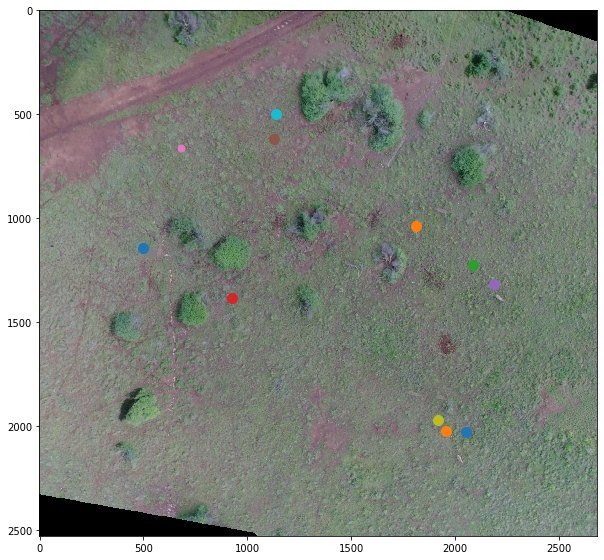

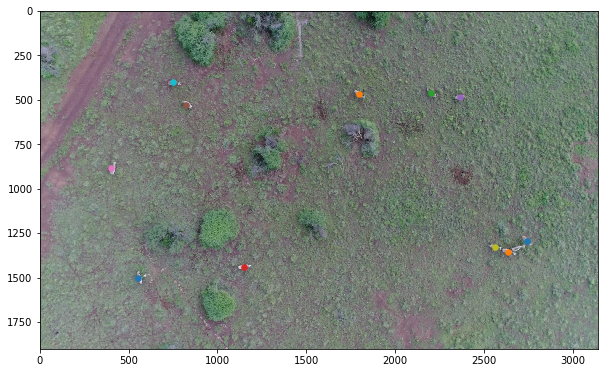

In [17]:
save = False
show = True

frame_buffer = 400
map_buffer = .15 # fraction of range between max points to add as buffer
min_map_buffer = 500 # buffer should never be less than this

map_shape = image_map.shape

obs_inds_visualize = [136]

for obs_ind in obs_inds_visualize:
    
    raster_positions = []
    for utm_point in tracks_utm[obs_ind]:
        raster_point = kmap.utm_to_raster(utm_point[0], utm_point[1], 
                                          x_origin, y_origin, 
                                          pixel_width, pixel_height, 
                                          image_scale=1.0
                                         )
        raster_positions.append(raster_point)
    raster_positions = np.stack(raster_positions)
    
    frame_positions = []
    for track in tracks_frame:
        track_uv = kmap.get_track_position_at_obs_ind(track, obs_ind, demo_shape)
        if track_uv is False:
            # Track isn't present in this frame so just add nan
            track_uv = np.array([np.nan, np.nan])
        frame_positions.append(track_uv)
    frame_positions = np.stack(frame_positions)
    
    
    
    name = "{}-{}".format(observation_name, obs_ind)
    
    frame = cv2.imread(frame_files[obs_ind])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    max_x_raster = np.nanmax(raster_positions[:,0])
    min_x_raster = np.nanmin(raster_positions[:,0])
    max_y_raster = np.nanmax(raster_positions[:,1])
    min_y_raster = np.nanmin(raster_positions[:,1])
    
    x_buffer = int((max_x_raster - min_x_raster) * map_buffer)
    x_buffer = np.nanmax([x_buffer, min_map_buffer])
    y_buffer = int((max_y_raster - min_y_raster) * map_buffer)
    y_buffer = np.nanmax([y_buffer, min_map_buffer])
    
    
    max_x_raster = int(np.nanmin([max_x_raster+x_buffer, map_shape[1]]))
    min_x_raster = int(np.nanmax([min_x_raster-x_buffer, 0]))
    max_y_raster = int(np.nanmin([max_y_raster+y_buffer, map_shape[0]]))
    min_y_raster = int(np.nanmax([min_y_raster-y_buffer, 0]))
    
    max_x_frame = np.nanmax(frame_positions[:,0])
    min_x_frame = np.nanmin(frame_positions[:,0])
    max_y_frame = np.nanmax(frame_positions[:,1])
    min_y_frame = np.nanmin(frame_positions[:,1])
    
    max_x_frame = np.nanmin([max_x_frame+frame_buffer, frame.shape[1]]).astype(int)
    min_x_frame = np.nanmax([min_x_frame-frame_buffer, 0]).astype(int)
    max_y_frame = np.nanmin([max_y_frame+frame_buffer, frame.shape[0]]).astype(int)
    min_y_frame = np.nanmax([min_y_frame-frame_buffer, 0]).astype(int)
    
    cropped_image_map = image_map[min_y_raster:max_y_raster, min_x_raster:max_x_raster]
    cropped_frame = frame[min_y_frame:max_y_frame, min_x_frame:max_x_frame]
    
    if save:
        cropped_image_map = cv2.cvtColor(cropped_image_map, cv2.COLOR_BGR2RGB)
        cropped_frame = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)

        cv2.imwrite(os.path.join(output_frame_folder, name+'.jpg'), cropped_frame)
        cv2.imwrite(os.path.join(output_map_images_folder, name+'.jpg'), cropped_image_map)

    if show:
        plt.figure(figsize=(10,10))
        plt.imshow(cropped_image_map)
        for p_ind, raster_point in enumerate(raster_positions):
            if p_ind == 6:
                dot_size = 50
            else:
                dot_size = 100
            plt.scatter(raster_point[0]-min_x_raster, 
                        raster_point[1]-min_y_raster, 
                        s=dot_size
                       )
            
    if show:  
        plt.figure(figsize=(10,10))
        plt.imshow(cropped_frame)

    # first point is the minx and miny
    cropped_frame_positions = [np.array([min_x_frame, min_y_frame])]
    cropped_map_positions = [np.array([min_x_raster, min_y_raster])]
    for position in frame_positions:
        if show:
            plt.scatter(position[0]-min_x_frame, position[1]-min_y_frame, s=30)
            
        cropped_frame_positions.append(np.array([position[0]-min_x_frame, position[1]-min_y_frame]))
        cropped_map_positions.append(np.array([-1, -1])) # These will be corrected in the gui
        
    if save:
        np.save(os.path.join(output_frame_positions_folder, name+'.npy'),
                np.vstack(cropped_frame_positions))
        np.save(os.path.join(output_raster_positions_folder, name+'.npy'),
                np.vstack(cropped_map_positions))
        np.save(os.path.join(output_track_indicies_folder, name+'.npy'),
                track_indicies)

In [18]:
image_map[min_y_raster:max_y_raster, min_x_raster:max_x_raster]

array([[[108, 118, 110],
        [108, 118, 111],
        [108, 119, 111],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[108, 118, 110],
        [108, 119, 111],
        [109, 120, 112],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[107, 117, 110],
        [108, 118, 111],
        [109, 120, 112],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [130, 141, 134],
        [132, 143, 136],
        [135, 145, 139]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [131, 143, 136],
        [134, 146, 138],
        [137, 148, 141]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [134, 146, 139],
        [136, 148, 140],
        [138, 149, 142]]

In [28]:
min_y_raster, max_y_raster

(0, -7052085)

In [29]:
min_x_raster, max_x_raster

(23661, 26349)

In [36]:
y_origin, tracks_utm[0,0,1], pixel_height

(39182.73663000001, 38982.995370000004, -0.03218)

In [31]:
raster_positions

array([[   25724., -7054147.],
       [   25471., -7053895.],
       [   25756., -7054180.],
       [   24592., -7053015.],
       [   25849., -7054272.],
       [   24798., -7053222.],
       [   24287., -7052710.],
       [   24197., -7052621.],
       [   25586., -7054010.],
       [   24797., -7053220.],
       [   24161., -7052585.],
       [   25618., -7054041.],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [      nan,       nan],
       [